<a href="https://colab.research.google.com/github/jrim42/plant_bacteriology_lab/blob/main/Expr3_callose_deposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import sem
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal
import cv2
from google.colab.patches import cv2_imshow
import os
from scipy.stats import f_oneway

---
## **saving data**

In [2]:
root_path = "./drive/MyDrive/coding/plant_bacteriology/result/"
group_names = ['A', 'B', 'C', 'D']
paths = [root_path + f"group{group_name}/" for group_name in group_names]

groupA = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
groupB = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
groupC = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
groupD = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}

groups = [groupA, groupB, groupC, groupD]

In [3]:
def group_files(directory_path, group_dict):
    files = [f for f in os.listdir(directory_path) if f.endswith(('.png'))]

    for file_name in files:
        if 'D36E' in file_name:
            group_dict['D36E'].append(file_name)
        elif 'hrcC' in file_name:
            group_dict['hrcC'].append(file_name)
        elif 'hopQ1' in file_name:
            group_dict['hopQ1'].append(file_name)
        elif 'mock' in file_name:
            group_dict['mock'].append(file_name)

In [4]:
# adding file names in dict
for i, group_dict in enumerate(groups):
    group_directory = paths[i]
    group_files(group_directory, group_dict)

# sorting values(file names) in dict order
for group_dict in groups:
    for key, value in group_dict.items():
        group_dict[key] = sorted(value)

In [5]:
# printing result
for i, group_dict in enumerate(groups):
    print(f"Group {group_names[i]}:")
    for key, value in group_dict.items():
        print(f"{key}: {value}")
    print()

Group A:
D36E: ['A D36E 1.png', 'A D36E 2.png', 'A D36E 3.png', 'A D36E 4.png']
hrcC: ['A hrcC 1.png', 'A hrcC 2.png', 'A hrcC 3.png', 'A hrcC 4.png']
hopQ1: ['A hopQ1 1.png', 'A hopQ1 2.png', 'A hopQ1 3.png', 'A hopQ1 4.png']
mock: ['A mock 1.png', 'A mock 2.png', 'A mock 3.png', 'A mock 4.png']

Group B:
D36E: ['B D36E 1.png', 'B D36E 2.png', 'B D36E 3.png', 'B D36E 4.png']
hrcC: ['B hrcC 1.png', 'B hrcC 2.png', 'B hrcC 3.png', 'B hrcC 4.png']
hopQ1: ['B hopQ1 1.png', 'B hopQ1 2.png', 'B hopQ1 3.png', 'B hopQ1 4.png']
mock: ['B mock 1.png', 'B mock 2.png', 'B mock 3.png', 'B mock 4.png']

Group C:
D36E: ['C D36E 1.png', 'C D36E 2.png', 'C D36E 3.png', 'C D36E 4.png']
hrcC: ['C hrcC 1.png', 'C hrcC 2.png', 'C hrcC 3.png', 'C hrcC 4.png']
hopQ1: ['C hopQ1 1.png', 'C hopQ1 2.png', 'C hopQ1 3.png', 'C hopQ1 4.png']
mock: ['C mock 1.png', 'C mock 2.png', 'C mock 3.png', 'C mock 4.png']

Group D:
D36E: ['D D36E 1.png', 'D D36E 2.png', 'D D36E 3.png', 'D D36E 4.png']
hrcC: ['D hrcC 1.png', 

---
## **image preprocessing and measurement**

In [6]:
def brightenImg(img):
    alpha = 0.6
    adjusted_img = np.clip((1 + alpha) * img - 128 * alpha, 0, 255).astype(np.uint8)
    return adjusted_img

In [7]:
def contrastImg(img):
    # converting image to LAB Color model
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # splitting the LAB image to different channels
    l, a, b = cv2.split(lab)

    # applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl, a, b))

    # converting image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return final

In [8]:
def calculate_ratio(img):
    h, w, c = img.shape

    # boundary of color range
    lower_bound = np.array([0x0D, 0x0D, 0xFF], dtype=np.uint8)
    upper_bound = np.array([0x00, 0x00, 0x30], dtype=np.uint8)

    # detecting pixel in the range
    mask = cv2.inRange(img, upper_bound, lower_bound)

    # counting the number of pixels
    pixels_in_range = cv2.countNonZero(mask)

    # extract specific pixels
    # result_img = np.zeros_like(img)
    # result_img[mask > 0] = img[mask > 0]

    ratio = pixels_in_range / (h * w) * 100
    ratio = round(ratio, 4)
    return ratio

In [9]:
ratioA = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
ratioB = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
ratioC = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
ratioD = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}

ratios = [ratioA, ratioB, ratioC, ratioD]

editA = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
editB = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
editC = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}
editD = {'D36E': [], 'hrcC': [], 'hopQ1': [], 'mock': []}

edits = [editA, editB, editC, editD]

# Iterate over groups and files
for i, group_dict in enumerate(groups):
    for key, files in group_dict.items():
        for file in files:
            image_path = os.path.join(paths[i], file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if img is not None:
                img = brightenImg(img)
                img = contrastImg(img)
                ratio = calculate_ratio(img)
                edits[i][key].append(img)
                ratios[i][key].append(ratio)

In [10]:
# print results
for i, ratio_dict in enumerate(ratios):
    print(f"Analysis results for group {group_names[i]}:")
    for key, value in ratio_dict.items():
        print(f"{key}: {value}")
    print()

Analysis results for group A:
D36E: [0.0, 0.0039, 0.1146, 0.005]
hrcC: [0.0296, 0.0951, 0.1573, 0.1654]
hopQ1: [0.0148, 0.0017, 0.0955, 0.022]
mock: [0.0002, 0.0, 0.0, 0.0]

Analysis results for group B:
D36E: [0.1113, 0.1354, 0.0, 0.0]
hrcC: [0.0039, 0.0018, 0.0019, 0.0]
hopQ1: [0.0, 0.0, 0.0, 0.0]
mock: [0.0, 0.0, 0.0, 0.0]

Analysis results for group C:
D36E: [0.1356, 0.2331, 0.0904, 0.0049]
hrcC: [0.2948, 0.3048, 0.2952, 0.3164]
hopQ1: [0.2002, 0.0652, 0.0896, 0.0416]
mock: [0.0, 0.0, 0.026, 0.0411]

Analysis results for group D:
D36E: [0.1679, 0.1132, 0.2115, 0.2834]
hrcC: [0.15, 0.1521, 0.0, 0.0001]
hopQ1: [0.0928, 0.029, 0.0652, 0.1159]
mock: [0.0111, 0.0, 0.0, 0.0166]



---
## **calculation**

In [11]:
meanA = {'D36E': round(np.mean(ratioA['D36E']), 3),
         'hrcC': round(np.mean(ratioA['hrcC']), 3),
         'hopQ1': round(np.mean(ratioA['hopQ1']), 3),
         'mock': round(np.mean(ratioA['mock']), 3)}

meanB = {'D36E': round(np.mean(ratioB['D36E']), 3),
         'hrcC': round(np.mean(ratioB['hrcC']), 3),
         'hopQ1': round(np.mean(ratioB['hopQ1']), 3),
         'mock': round(np.mean(ratioB['mock']), 3)}

meanC = {'D36E': round(np.mean(ratioC['D36E']), 3),
         'hrcC': round(np.mean(ratioC['hrcC']), 3),
         'hopQ1': round(np.mean(ratioC['hopQ1']), 3),
         'mock': round(np.mean(ratioC['mock']), 3)}

meanD = {'D36E': round(np.mean(ratioD['D36E']), 3),
         'hrcC': round(np.mean(ratioD['hrcC']), 3),
         'hopQ1': round(np.mean(ratioD['hopQ1']), 3),
         'mock': round(np.mean(ratioD['mock']), 3)}

meanT = {'D36E': round(np.mean(ratioA['D36E'] + ratioB['D36E'] + ratioC['D36E'] + ratioD['D36E']), 3),
         'hrcC': round(np.mean(ratioA['hrcC'] + ratioB['hrcC'] + ratioC['hrcC'] + ratioD['hrcC']), 3),
         'hopQ1': round(np.mean(ratioA['hopQ1'] + ratioB['hopQ1'] + ratioC['hopQ1'] + ratioD['hopQ1']), 3),
         'mock': round(np.mean(ratioA['mock'] + ratioB['mock'] + ratioC['mock'] + ratioD['mock']), 3),}

In [12]:
df = pd.DataFrame(
    {'D36E': [meanA['D36E'], meanB['D36E'], meanC['D36E'], meanD['D36E'], meanT['D36E']],
    'hrcC': [meanA['hrcC'], meanB['hrcC'], meanC['hrcC'], meanD['hrcC'], meanT['hrcC']],
    'hopQ1': [meanA['hopQ1'], meanB['hopQ1'], meanC['hopQ1'], meanD['hopQ1'], meanT['hopQ1']],
    'mock': [meanA['mock'], meanB['mock'], meanC['mock'], meanD['mock'], meanT['mock']]},
    index = ['A', 'B', 'C', 'D', 'total'])

df

,D36E,hrcC,hopQ1,mock
A,0.031,0.112,0.034,0.000
B,0.062,0.002,0.000,0.000
C,0.116,0.303,0.099,0.017
D,0.194,0.076,0.076,0.007
total,0.101,0.123,0.052,0.006


In [13]:
# Calculate mean and standard error for each key
means = []
std_errs = []
for ratio in ratios:
    means.append([np.mean(ratio[key]) for key in ratio.keys()])
    std_errs.append([np.std(ratio[key], ddof=1) / np.sqrt(len(ratio[key])) for key in ratio.keys()])

# Calculate mean and standard error for the combined data
meanT = [round(np.mean(item), 4) for item in zip(*means)]
std_errT = [round(np.std(item, ddof=1) / np.sqrt(len(item)), 4) for item in zip(*means)]

dfT = pd.DataFrame(
    {'D36E': [meanT[0], std_errT[0]],
    'hrcC': [meanT[1], std_errT[1]],
    'hopQ1': [meanT[2], std_errT[2]],
    'mock': [meanT[3], std_errT[3]]},
    index = ['mean', 'stderr'])

dfT

,D36E,hrcC,hopQ1,mock
mean,0.1006,0.1230,0.0521,0.0059
stderr,0.0358,0.0641,0.0220,0.0040


---
## **visualization**

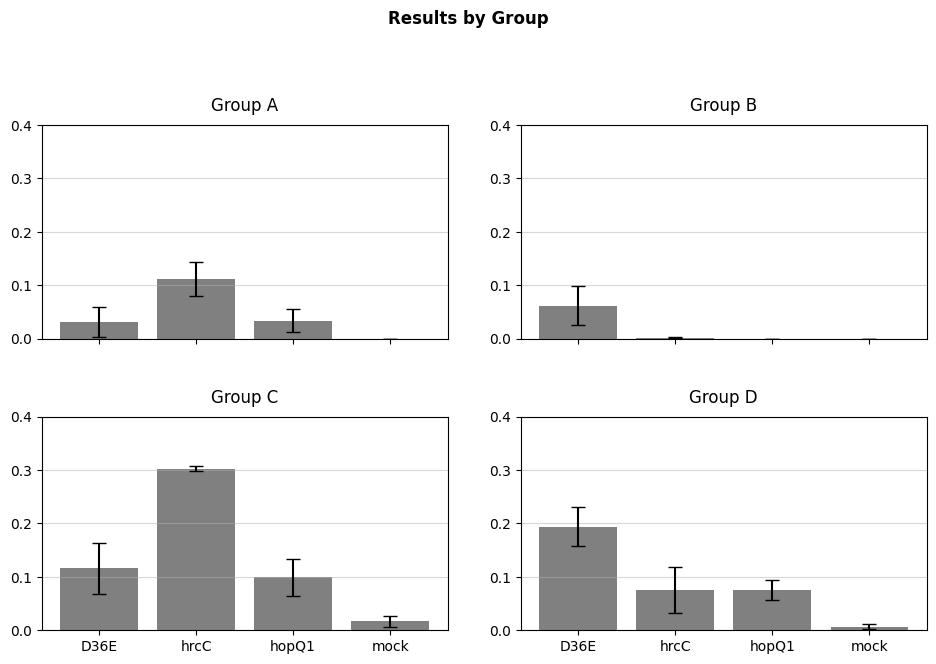

In [14]:
# Plot bar chart with error bars
fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=True)
fig.suptitle("Results by Group", fontweight="bold")

groups = ['Group A', 'Group B', 'Group C', 'Group D']
keys = list(ratios[0].keys())
for i in range(4):
    ax = axs[i // 2, i % 2]
    x = np.arange(len(keys))
    bars = ax.bar(x, means[i], yerr=std_errs[i], capsize=5, color='gray', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.set_title(groups[i], pad=10)
    ax.set_ylim(0, 0.4)

    # Annotate bars with values (without error)
    # for j, bar in enumerate(bars):
    #     yval = bar.get_height()
        # ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{round(yval, 4)}', ha='center', va='bottom')

    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.grid(axis='y', linestyle='-', alpha=0.5)

plt.tight_layout(pad=3)
plt.show()

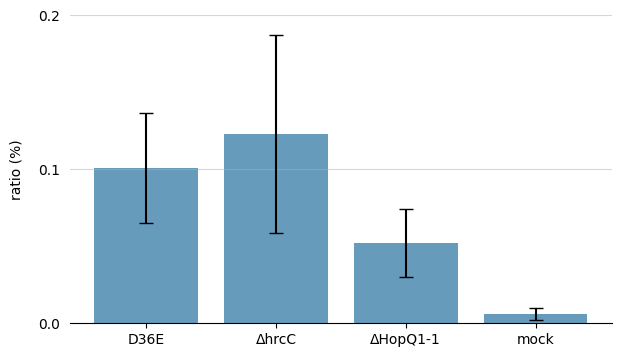

In [36]:
# Plot bar chart with error bars
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(dfT.columns))

groups = ['D36E', 'ΔhrcC', 'ΔHopQ1-1', 'mock']

bars = ax.bar(x, meanT, yerr=std_errT, capsize=5, color='#669bbc', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)
ax.set_ylim(0, 0.2)

ax.set_ylabel('ratio (%)', labelpad=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.grid(axis='y', linestyle='-', alpha=0.5)

# ax.set_title("Results Summary (all groups)", fontweight="bold", pad=10)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

---
## **images**

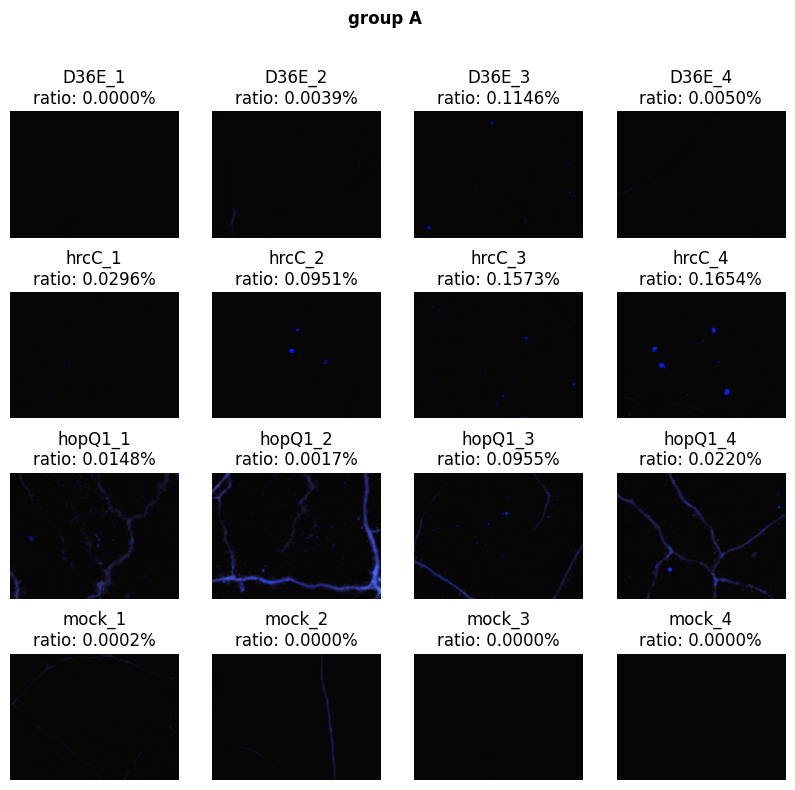

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(10, 9))
plt.suptitle("group A", fontweight="bold")

for i, (key, images) in enumerate(editA.items()):
    ratio_values = ratioA[key]
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{key}_{j+1}\nratio: {ratio_values[j]:.4f}%")

plt.show()

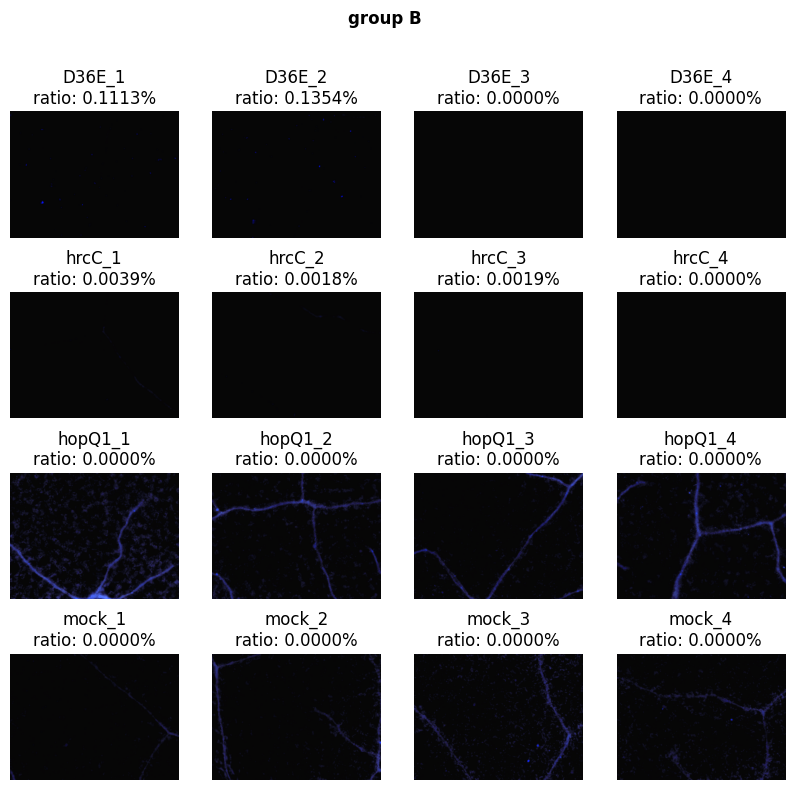

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(10, 9))
plt.suptitle("group B", fontweight="bold")

for i, (key, images) in enumerate(editB.items()):
    ratio_values = ratioB[key]
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{key}_{j+1}\nratio: {ratio_values[j]:.4f}%")

plt.show()

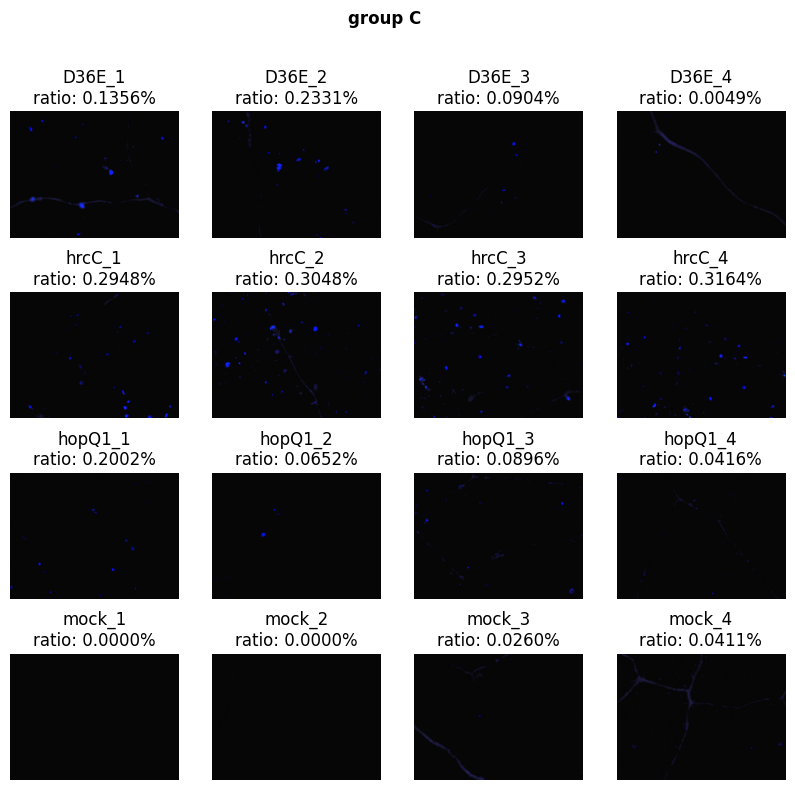

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(10, 9))
plt.suptitle("group C", fontweight="bold")

for i, (key, images) in enumerate(editC.items()):
    ratio_values = ratioC[key]
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{key}_{j+1}\nratio: {ratio_values[j]:.4f}%")

plt.show()

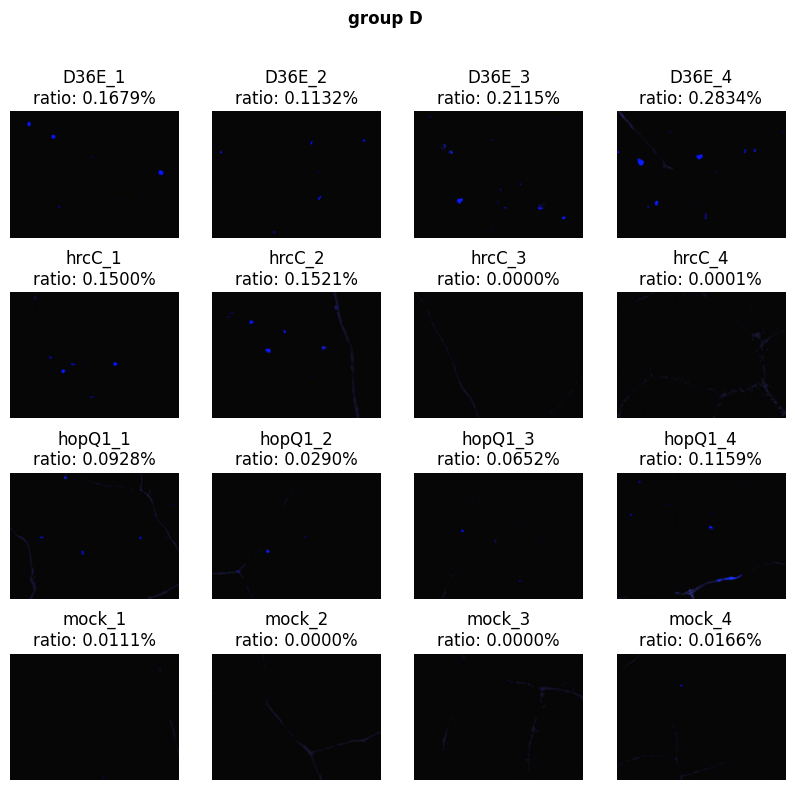

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(10, 9))
plt.suptitle("group D", fontweight="bold")

for i, (key, images) in enumerate(editD.items()):
    ratio_values = ratioD[key]
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{key}_{j+1}\nratio: {ratio_values[j]:.4f}%")

plt.show()

---

### **statistical anaylsis**

In [20]:
ratioT = {
    'D36E': ratioA['D36E'] + ratioB['D36E'] + ratioC['D36E'] + ratioD['D36E'],
    'hrcC': ratioA['hrcC'] + ratioB['hrcC'] + ratioC['hrcC'] + ratioD['hrcC'],
    'hopQ1': ratioA['hopQ1'] + ratioB['hopQ1'] + ratioC['hopQ1'] + ratioD['hopQ1'],
    'mock': ratioA['mock'] + ratioB['mock'] + ratioC['mock'] + ratioD['mock'],
}

print("D36E:", ratioT['D36E'])
print("hrcC:", ratioT['hrcC'])
print("hopQ1:", ratioT['hopQ1'])
print("mock:", ratioT['mock'])

D36E: [0.0, 0.0039, 0.1146, 0.005, 0.1113, 0.1354, 0.0, 0.0, 0.1356, 0.2331, 0.0904, 0.0049, 0.1679, 0.1132, 0.2115, 0.2834]
hrcC: [0.0296, 0.0951, 0.1573, 0.1654, 0.0039, 0.0018, 0.0019, 0.0, 0.2948, 0.3048, 0.2952, 0.3164, 0.15, 0.1521, 0.0, 0.0001]
hopQ1: [0.0148, 0.0017, 0.0955, 0.022, 0.0, 0.0, 0.0, 0.0, 0.2002, 0.0652, 0.0896, 0.0416, 0.0928, 0.029, 0.0652, 0.1159]
mock: [0.0002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.026, 0.0411, 0.0111, 0.0, 0.0, 0.0166]


In [21]:
# ANOVA of groupC data
anova_results = pd.DataFrame(columns=['Key1', 'Key2', 'F-statistic', 'p-value'])

keys = list(ratioC.keys())
for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        key1 = keys[i]
        key2 = keys[j]

        f_statistic, p_value = f_oneway(ratioC[key1], ratioC[key2])
        formatted_p_value = '{:.7f}'.format(p_value)
        anova_results = pd.concat([anova_results, pd.DataFrame({'Key1': [key1], 'Key2': [key2], 'F-statistic': [f_statistic], 'p-value': [formatted_p_value]})], ignore_index=True)

print("> ANOVA test of groupC\n")
anova_results

> ANOVA test of groupC



,Key1,Key2,F-statistic,p-value
0,D36E,hrcC,15.278881,0.0079031
1,D36E,hopQ1,0.081388,0.7850172
2,D36E,mock,4.169693,0.0872047
3,hrcC,hopQ1,33.007831,0.0012096
4,hrcC,mock,633.236273,0.0000003
5,hopQ1,mock,5.087158,0.0649509


In [22]:
# ANOVA of total data
anova_results = pd.DataFrame(columns=['Key1', 'Key2', 'F-statistic', 'p-value'])

keys = list(ratioT.keys())
for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        key1 = keys[i]
        key2 = keys[j]

        f_statistic, p_value = f_oneway(ratioT[key1], ratioT[key2])
        formatted_p_value = '{:.7f}'.format(p_value)
        anova_results = pd.concat([anova_results, pd.DataFrame({'Key1': [key1], 'Key2': [key2], 'F-statistic': [f_statistic], 'p-value': [p_value]})], ignore_index=True)

print("> ANOVA test of total data\n")
anova_results

> ANOVA test of total data



,Key1,Key2,F-statistic,p-value
0,D36E,hrcC,0.332843,0.568294
1,D36E,hopQ1,3.205174,0.083504
2,D36E,mock,16.427671,0.000330
3,hrcC,hopQ1,4.309272,0.046573
4,hrcC,mock,14.014489,0.000769
5,hopQ1,mock,10.260292,0.003212
